# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input Reading

## reading

In [3]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
#name = 'tm_mesons_run11.mesons'
#name = 'tm_mesons_run12.mesons'
name = 'tm_mesons_run13.mesons'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [7]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

100.0

In [8]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

100

In [9]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [10]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(100, 10, 32, 100)


In [11]:
if verbose:
    for icorr in range(ncorr):
        print(f"k1  = {k1[icorr]}\n")
        print(f"k2  = {k2[icorr]}\n")
        print(f"mu1 = {mu1[icorr]}\n")
        print(f"mu2 = {mu2[icorr]}\n")
        print(f"G1  = {type1[icorr]}\n")
        print(f"G2  = {type2[icorr]}\n")
        print(f"x0  = {x0[icorr]}\n")
        print(f"isr = {isreal[icorr]}\n\n")

k1  = 0.135217

k2  = 0.135217

mu1 = 0.0113

mu2 = 0.0113

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0113

mu2 = -0.0113

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = 0.0151

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = -0.0151

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0302

mu2 = 0.0302

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0302

mu2 = -0.0302

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = -0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = 0.0605

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = -0.0605

G1  = 5

G2  = 5

x0  = 1

isr = 0




In [12]:
true_masses = np.asarray([0.2150,0.2449,0.3401,0.4182,0.4873])
mus = np.array(mu1[::2])

## cast to real

In [43]:
correlators = correlators.real

## average over noise

In [44]:
corr_navg = correlators.mean(axis=-1)
if verbose:
    print("(nconf, ncorrelators, tvals)")
    print(np.shape(corr_navg))

(nconf, ncorrelators, tvals)
(100, 10, 32)


## preliminary plots

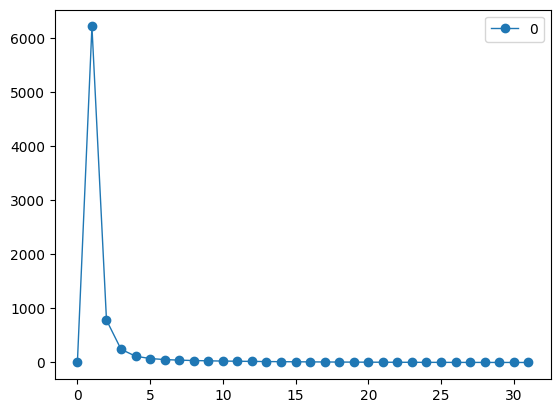

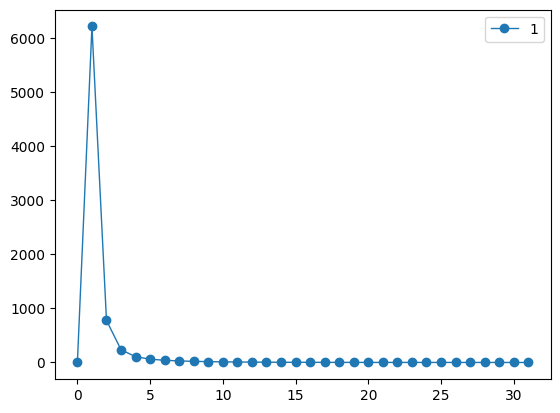

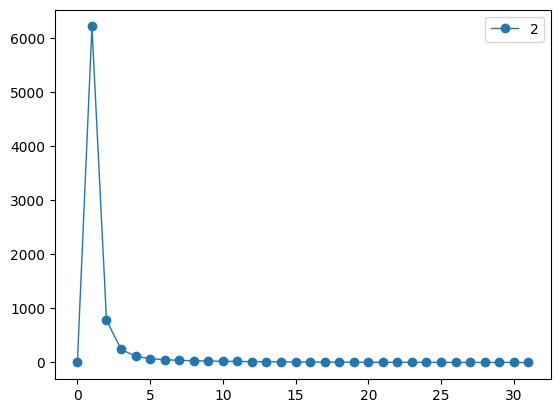

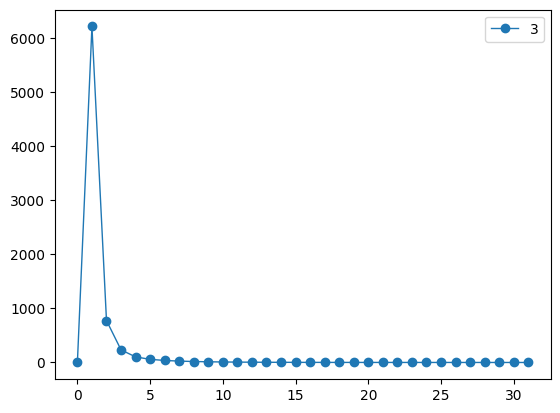

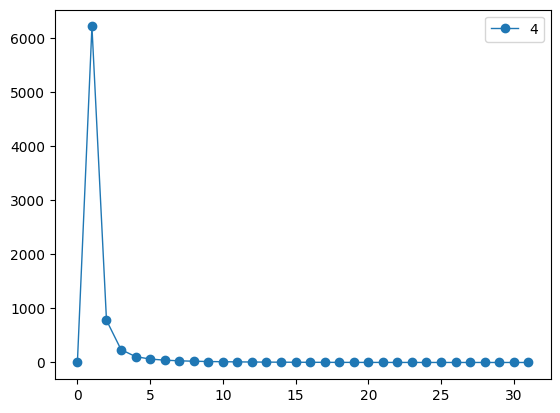

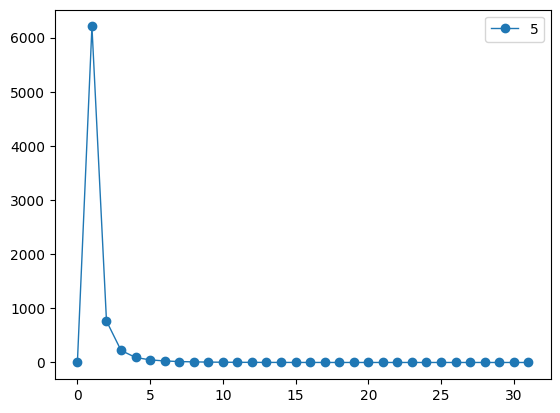

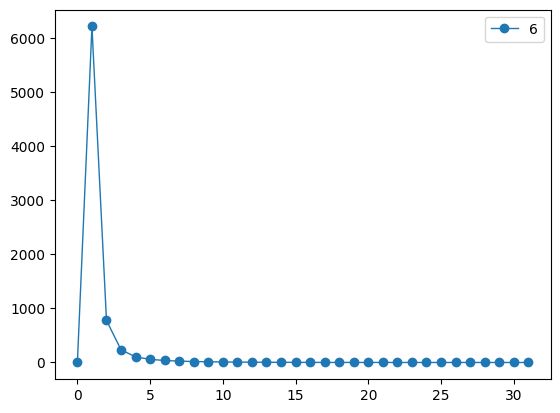

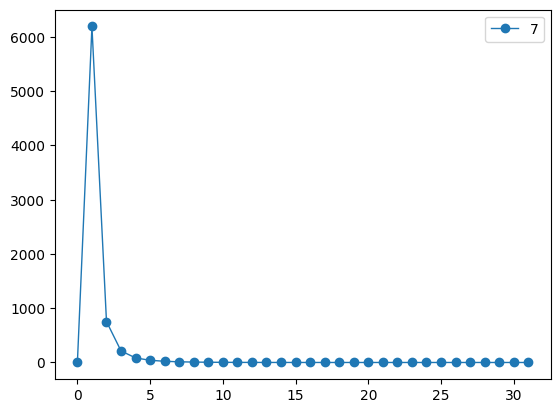

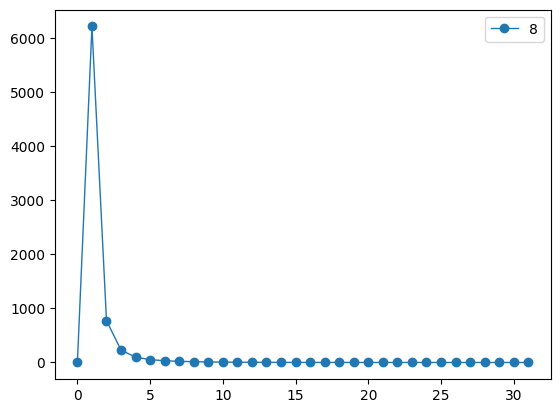

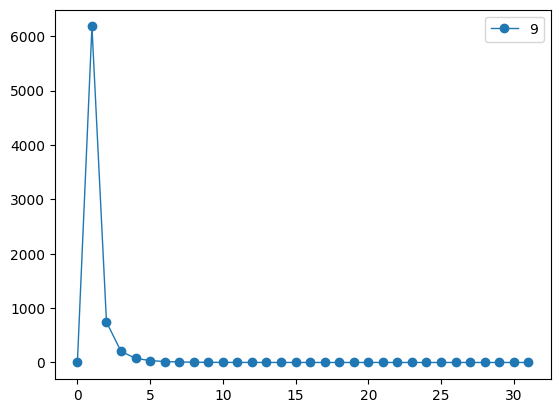

In [45]:
times = np.arange(tvals)

for ic in range(ncorr):
    _=plt.figure()
    _=plt.plot(times,np.mean(corr_navg[:,ic,:],axis=0).real, '-o',linewidth = 1,label=str(ic))
    _=plt.legend()

In [46]:
def mass(corr_ratio,t,verb=False):

    #it = 0
    max_it = 150
    eps=10^-5

    Time = tvals-1

    m0 = np.log(corr_ratio)

    massa = m0 #at iteration 0 the sinh is an exp and the mass is simply the log of the ration of correlators

    if corr_ratio <1.0:
        massa = 0
        return massa

    for it in range(max_it):


        '''
        if tvals-2*(t-1) -2 == 0 or tvals-2*(t-1) +2 ==0:
           break
        '''        
        

        #computes new mass from previous one
        
        #new_m = np.log(corr_ratio * (1-np.exp(-2*old_m*(tvals-t-1)))/(1-np.exp(-2*old_m*(tvals-t)) ) )

        den = 1 - np.exp( -2*massa * ( Time-t  ) )
        num = 1 - np.exp( -2*massa * ( Time-t-1) )
        

        new_massa = np.log( corr_ratio * num/den )

        if it%30 == 0 and verb==True:
            print(f"x t{t} it{it} delta = {np.abs((new_massa-massa)/massa)} \n")
        
        #if np.abs((new_m-old_m)/old_m)<eps:
            #break

        '''
        if np.abs(new_massa)>4.0 or new_massa<0:
            massa = 10
            break
        '''

        
        if np.abs(massa-new_massa)/massa < 3e-7:
            massa=new_massa
            break
        

        massa = new_massa

    return massa

# Jacknife with effective and fit mass

In [113]:
def chi2(result,data,data_std):
    return np.sum( ((result-data)/data_std)**2 )

def fit_sinh_x(t,amp,mass):
    return amp*np.sinh(mass*(tvals-1-t)) #tvals-1 because T=tvals-1
    #return amp*np.sinh(mass*(tvals-t))

def mass(corr_ratio,t,verb=False):

    #it = 0
    max_it = 150
    eps=10^-5

    Time = tvals-1
    #Time = tvals

    m0 = np.log(corr_ratio)

    massa = m0 #at iteration 0 the sinh is an exp and the mass is simply the log of the ration of correlators

    if corr_ratio <1.0:
        massa = 0
        return massa

    for it in range(max_it):


        '''
        if tvals-2*(t-1) -2 == 0 or tvals-2*(t-1) +2 ==0:
           break
        '''        
        

        #computes new mass from previous one
        
        #new_m = np.log(corr_ratio * (1-np.exp(-2*old_m*(tvals-t-1)))/(1-np.exp(-2*old_m*(tvals-t)) ) )

        den = 1 - np.exp( -2*massa * ( Time-t  ) )
        num = 1 - np.exp( -2*massa * ( Time-t-1) )
        

        new_massa = np.log( corr_ratio * num/den )

        if it%30 == 0 and verb==True:
            print(f"x t{t} it{it} delta = {np.abs((new_massa-massa)/massa)} \n")
        
        #if np.abs((new_m-old_m)/old_m)<eps:
            #break

        '''
        if np.abs(new_massa)>4.0 or new_massa<0:
            massa = 10
            break
        '''

        
        if np.abs(massa-new_massa)/massa < 3e-7:
            massa=new_massa
            break
        

        massa = new_massa

    return massa

## Average over Noise

In [114]:
#it is already done above
if verbose:
    print("(nconf,ncorr,tvals)")
    print(np.shape(corr_navg))

(nconf,ncorr,tvals)
(100, 10, 32)


## Creation of jackknife Replicates

In [115]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_navg_resamp = np.asarray( [np.delete(corr_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,ncorr,tvals)")
    print(np.shape(corr_navg_resamp))

(nresamples,nconf-delta,ncorr,tvals)
(100, 99, 10, 32)


## Correlator Identification

In [116]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_navg_resamp_gavg = corr_navg_resamp.mean(axis=1)

#this is the array with the replicates !!!
eff_mass_array = np.empty(shape=(ncorr,nresamples,tvals-1),dtype=float)
fit_mass_array = np.empty(shape=(ncorr,nresamples),dtype=float)
fit_amp_array = np.empty(shape=(ncorr,nresamples),dtype=float)


#then we estimate the mass
for icorr in range(ncorr):


    #preparation for fit
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]
    

    
    for ires in range(nresamples):
        
        for t in range(tvals-1):
            #insert here the formula for the mass:
            eff_mass_array[icorr,ires,t] = mass( corr_navg_resamp_gavg[ires,icorr,t].real /  corr_navg_resamp_gavg[ires,icorr,t+1].real , t)

        #mass from fit for each of the replicate
        guess_amp=corr_navg_resamp_gavg[ires,icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
        guess=[guess_amp,guess_mass]
        fit_data=corr_navg_resamp_gavg[ires,icorr,cut:-cut].real
        popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)
        perr_x = np.sqrt(np.diag(pcov_x))
        fit_mass_array[icorr,ires] = popt_x[1]
        fit_amp_array[icorr,ires] = popt_x[0]



#we then estimate the mass also on the whole dataset
corr_navg_gavg = corr_navg.mean(axis=0)

#this is the array with the mass computed on the whole dataset !!!
eff_mass_array_jacktotal = np.empty(shape=(ncorr,tvals-1),dtype=float)
fit_mass_array_jacktotal = np.empty(shape=(ncorr),dtype=float)
fit_amp_array_jacktotal = np.empty(shape=(ncorr),dtype=float)

for icorr in range(ncorr):

    #preparation for fit
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]

    
    for t in range(tvals-1):
        eff_mass_array_jacktotal[icorr,t] = mass( corr_navg_gavg[icorr,t].real / corr_navg_gavg[icorr,t+1].real , t, verb=True)


    #mass from fit for each of the replicate
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    fit_data=corr_navg_gavg[icorr,cut:-cut].real
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    fit_mass_array_jacktotal[icorr] = popt_x[1]
    fit_amp_array_jacktotal[icorr] = popt_x[0]




if verbose:
    print("(nresamples,ncorr,tvals)")
    print(np.shape(corr_navg_resamp_gavg))
    
    print("(ncorr,tvals)")
    print(np.shape(corr_navg_gavg))

/tmp/ipykernel_23684/1754528214.py:17: RuntimeWarning: divide by zero encountered in log
  m0 = np.log(corr_ratio)
/tmp/ipykernel_23684/1699236235.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_array[icorr,ires,t] = mass( corr_navg_resamp_gavg[ires,icorr,t].real /  corr_navg_resamp_gavg[ires,icorr,t+1].real , t)
/tmp/ipykernel_23684/1754528214.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  num = 1 - np.exp( -2*massa * ( Time-t-1) )


x t1 it0 delta = 0.0 

x t2 it0 delta = 0.0 

x t3 it0 delta = 0.0 

x t4 it0 delta = 4.1908455705847266e-11 

x t5 it0 delta = 4.026605038672051e-07 

x t6 it0 delta = 3.81559773975201e-05 

x t7 it0 delta = 0.0003919808867001016 

x t8 it0 delta = 0.0012178518893805497 

x t9 it0 delta = 0.0036700070033139475 

x t10 it0 delta = 0.005952456705827073 

x t11 it0 delta = 0.00898084639433856 

x t12 it0 delta = 0.00898085557360616 

x t13 it0 delta = 0.010222347842818797 

x t14 it0 delta = 0.015130229927596479 

x t15 it0 delta = 0.021914416531963982 

x t16 it0 delta = 0.016220349455502776 

x t17 it0 delta = 0.01748770859392326 

x t18 it0 delta = 0.02305777769312333 

x t19 it0 delta = 0.03197156070050816 

x t20 it0 delta = 0.04744080884138486 

x t21 it0 delta = 0.05594339464032415 

x t22 it0 delta = 0.07428053260039541 

x t23 it0 delta = 0.0801575471396401 

x t24 it0 delta = 0.10806697037135934 

x t25 it0 delta = 0.14014454815762342 

x t26 it0 delta = 0.222871811925672 

x t

/tmp/ipykernel_23684/1699236235.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_array_jacktotal[icorr,t] = mass( corr_navg_gavg[icorr,t].real / corr_navg_gavg[icorr,t+1].real , t, verb=True)


In [117]:
#the estimate is the mean of the replicates
eff_estimate = np.mean(eff_mass_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
eff_bias = (nresamples-1) * (eff_estimate-eff_mass_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
eff_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (eff_mass_array[icorr] - eff_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
eff_estimate_biascorr = eff_estimate-eff_bias

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(eff_estimate_biascorr))
    print(np.shape(eff_std))


#the estimate is the mean of the replicates
fit_estimate = np.mean(fit_mass_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
fit_bias = (nresamples-1) * (fit_estimate-fit_mass_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
fit_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (fit_mass_array[icorr] - fit_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
fit_estimate_biascorr = fit_estimate-fit_bias

if verbose:
    print("(ncorr)")
    print(np.shape(fit_estimate_biascorr))
    print(np.shape(fit_std))


#the estimate is the mean of the replicates
amp_fit_estimate = np.mean(fit_amp_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
amp_fit_bias = (nresamples-1) * (amp_fit_estimate-fit_amp_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
amp_fit_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (fit_amp_array[icorr] - amp_fit_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
amp_fit_estimate_biascorr = amp_fit_estimate-amp_fit_bias

if verbose:
    print("(ncorr)")
    print(np.shape(fit_estimate_biascorr))
    print(np.shape(fit_std))

(ncorr,tvals)
(10, 31)
(10, 31)
(ncorr)
(10,)
(10,)
(ncorr)
(10,)
(10,)


In [118]:
M_fit = fit_estimate_biascorr
M_fit_std = fit_std

amp_fit = amp_fit_estimate_biascorr
amp_fit_std = amp_fit_std

In [119]:
sqM_fit = fit_estimate_biascorr**2
sqM_fit_std = 2*fit_estimate_biascorr*fit_std

M_eff = np.mean(eff_estimate_biascorr[:,cut:-cut],axis=1)
M_eff_std = np.sqrt( np.mean( eff_std[:,cut:-cut]**2 ,axis=1 ) )
sqM_eff = M_eff**2
sqM_eff_std = 2*M_eff*M_eff_std

sqM_true = true_masses**2

In [120]:
#M-Mtilda division

M2_fit = sqM_fit[::2]
M2_fit_std = sqM_fit_std[::2]

M2t_fit = sqM_fit[1::2]
M2t_fit_std = sqM_fit_std[1::2]


M2_eff = sqM_eff[::2]
M2_eff_std = sqM_eff_std[::2]

M2t_eff = sqM_eff[1::2]
M2t_eff_std = sqM_eff_std[1::2]

In [121]:
def fit_lin(x,m,q):
    return m * x + q

mu_range = np.linspace(0,np.max(mu1)*1.1,100)

guess_par = [ ( M2_fit[-1]+M2_fit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2_fit, sigma= M2_fit_std, p0=guess_par)
M2_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

guess_par = [ ( M2t_fit[-1]+M2t_fit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2t_fit, sigma= M2t_fit_std, p0=guess_par)
M2t_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

guess_par = [ ( M2_eff[-1]+M2_eff[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2_eff, sigma= M2_eff_std, p0=guess_par)
M2_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

guess_par = [ ( M2t_eff[-1]+M2t_eff[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2t_eff, sigma= M2t_eff_std, p0=guess_par)
M2t_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)



guess_par = [ ( sqM_true[-1]+sqM_true[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, sqM_true, p0=guess_par)
fit_reference = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

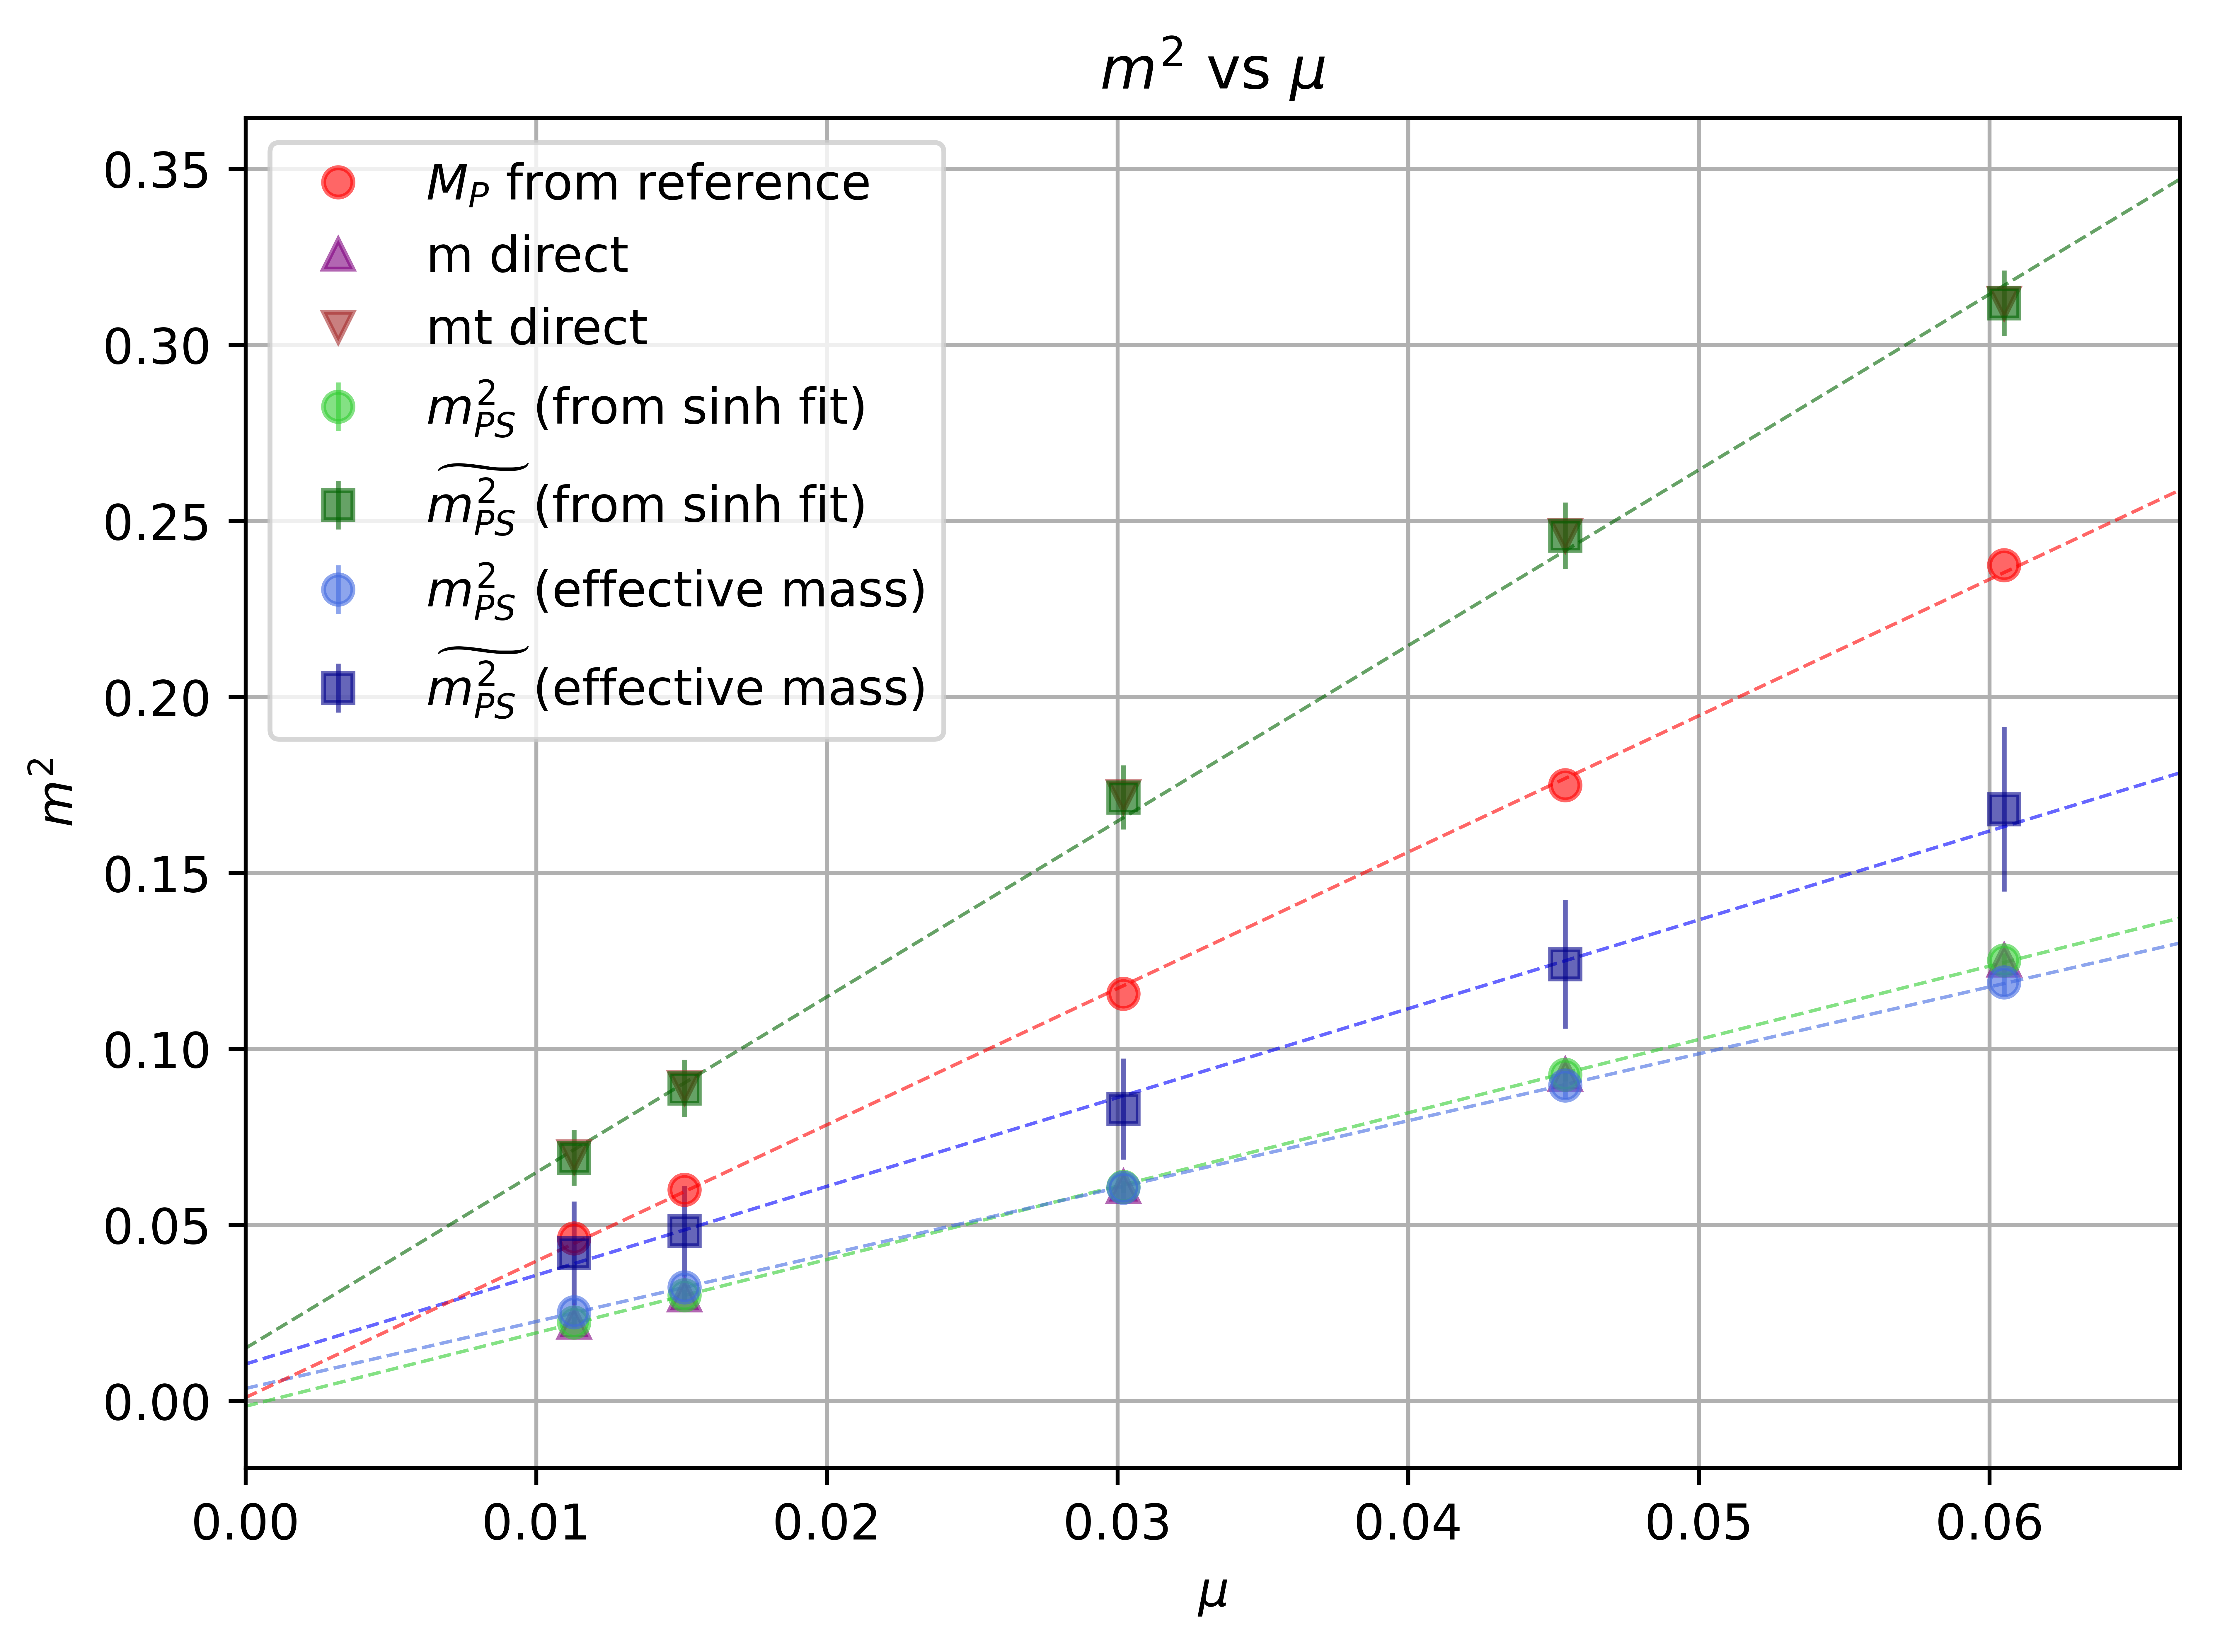

In [122]:
_=plt.figure(dpi=1200)

_=plt.errorbar(mus,M2_fit,M2_fit_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (from sinh fit)",color='limegreen',alpha=0.6)
_=plt.plot(mu_range,M2_fit_linfit,linewidth =0.7,linestyle='dashed',color='limegreen',alpha=0.6)
_=plt.errorbar(mus,M2t_fit,M2t_fit_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (from sinh fit)",color='darkgreen',alpha=0.6)
_=plt.plot(mu_range,M2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='darkgreen',alpha=0.6)

_=plt.errorbar(mus,M2_eff,M2_eff_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (effective mass)",color='royalblue',alpha=0.6)
_=plt.plot(mu_range,M2_eff_linfit,linewidth =0.7,linestyle='dashed',color='royalblue',alpha=0.6)
_=plt.errorbar(mus,M2t_eff,M2t_eff_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (effective mass)",color='darkblue',alpha=0.6)
_=plt.plot(mu_range,M2t_eff_linfit,linewidth =0.7,linestyle='dashed',color='blue',alpha=0.6)



_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
_=plt.plot(mu_range,fit_reference,linewidth =0.7,linestyle='dashed',color='red',alpha=0.6)


_=plt.plot(mus,mass_directfit[::2]**2,'^',label='m direct',linewidth =1,alpha=0.6,color='purple')
_=plt.plot(mus,mass_directfit[1::2]**2,'v',label='mt direct',linewidth =1,alpha=0.6,color='brown')

_=plt.xlim((0,np.max(mu1)*1.1))

_=plt.xlabel(r"$\mu$")


_=plt.legend()


_=plt.grid()

    
_=plt.title(r"$m^2$ vs $\mu$")
_=plt.ylabel(r"$m^2$")
_=plt.tight_layout()
#plt.savefig('mass_scaling_all.png')

# Fit Check

## Correlators from Jackknife

In [83]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_navg_resamp = np.asarray( [np.delete(corr_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,ncorr,tvals)")
    print(np.shape(corr_navg_resamp))

(nresamples,nconf-delta,ncorr,tvals)
(100, 99, 10, 32)


In [84]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_navg_resamp_gavg = corr_navg_resamp.mean(axis=1).real

#we then estimate the mass also on the whole dataset
corr_navg_gavg = corr_navg.mean(axis=0).real

if verbose:
    print("(nresamples,ncorr,tvals)")
    print(np.shape(corr_navg_resamp_gavg))
    print("(ncorr,tvals)")
    print(np.shape(corr_navg_gavg))

(nresamples,ncorr,tvals)
(100, 10, 32)
(ncorr,tvals)
(10, 32)


In [85]:
#the estimate is the mean of the replicates
corr_estimate = np.mean(corr_navg_resamp_gavg,axis=0) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
corr_bias = (nresamples-1) * (corr_estimate-corr_navg_gavg)
#the std is given by the following formula (variance of replicates times n-1)
corr_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (corr_navg_resamp_gavg[icorr] - corr_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
corr_estimate_biascorr = corr_estimate-corr_bias

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(corr_estimate_biascorr))
    print(np.shape(corr_std))

(ncorr,tvals)
(10, 32)
(10, 32)


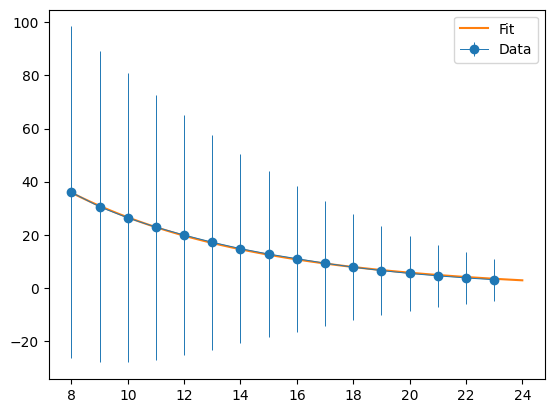

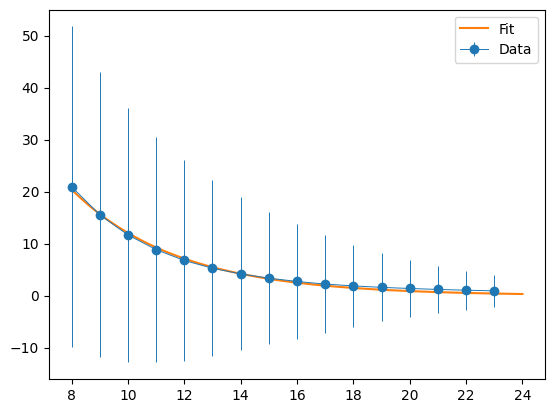

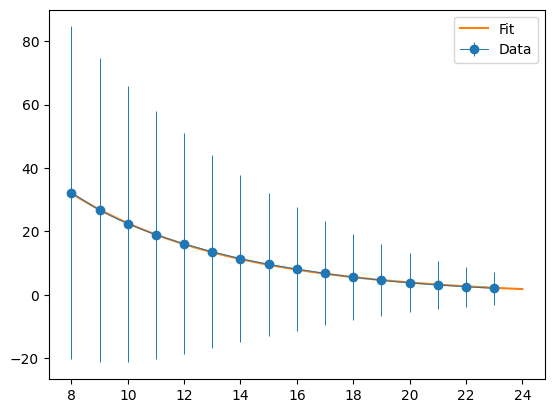

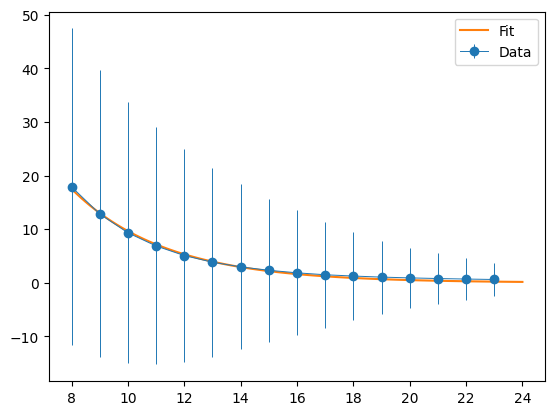

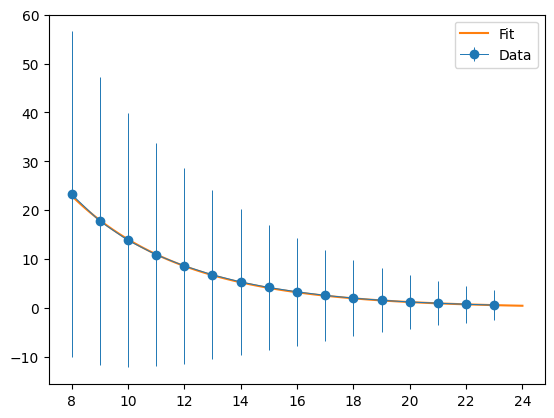

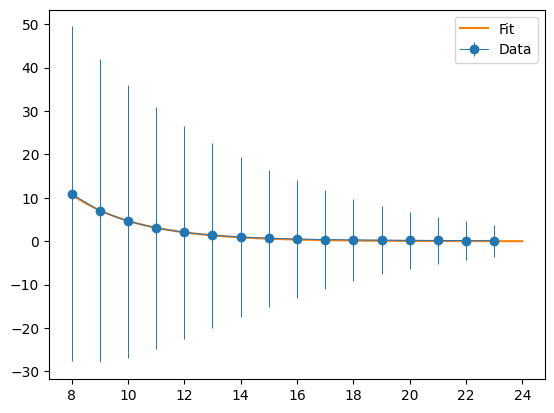

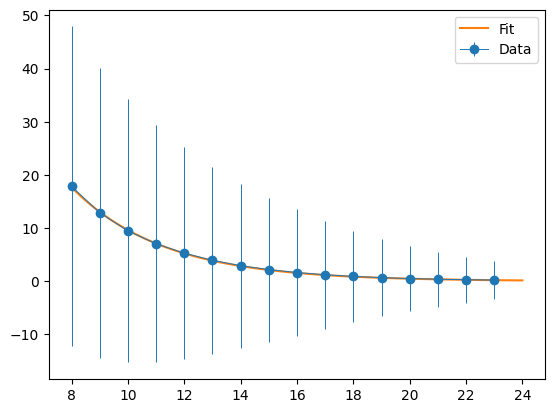

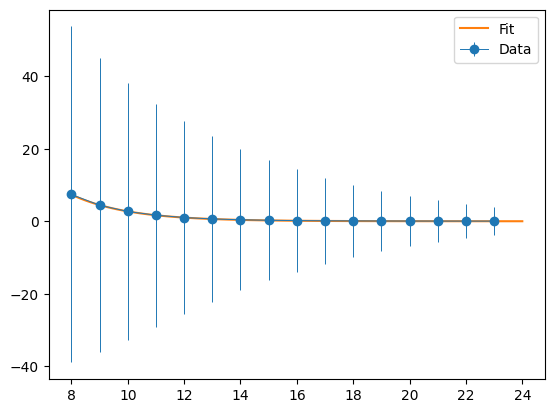

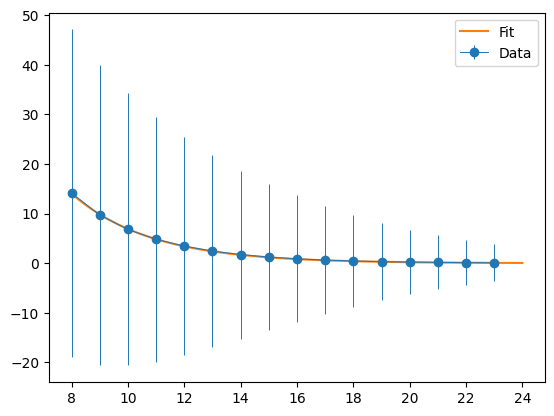

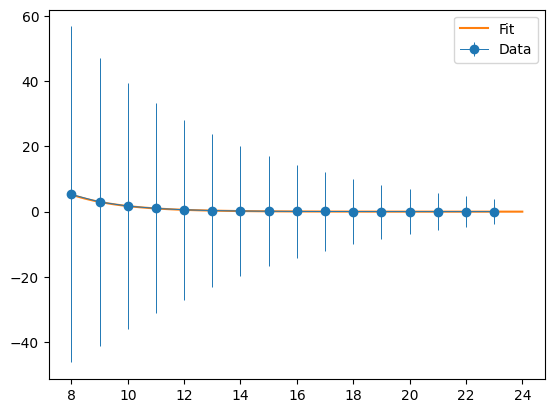

In [86]:
#fit on correlators
cut=8
times = np.arange(tvals)
fit_times=times[cut:-cut]
npoints=100
linspace_times = np.linspace(cut,tvals-cut,npoints)



mass_directfit = np.empty(shape=(ncorr),dtype=float)
amp_directfit = np.empty(shape=(ncorr),dtype=float)

corr_directfit = np.empty(shape=(ncorr,npoints),dtype=float)

#loop over correlators
for icorr in range(ncorr):


    guess_mass=true_masses[int(icorr/2)]
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    
    fit_data=corr_estimate_biascorr[icorr,cut:-cut].real
    
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    mass_directfit[icorr] = popt_x[1]
    amp_directfit[icorr] = popt_x[0]
    corr_directfit[icorr] = fit_sinh_x(linspace_times,*popt_x)


    _=plt.figure()
    _=plt.errorbar(times[cut:-cut],fit_data,corr_std[icorr,cut:-cut],marker='o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_directfit[icorr],label='Fit')
    #_=plt.xlim(cut,tvals-cut)
    #_=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()

In [66]:
mass_directfit

array([0.14949945, 0.26361795, 0.17332791, 0.29853744, 0.24661321,
       0.41439661, 0.30446509, 0.49598466, 0.353837  , 0.55851562])

In [88]:
'''
cut=8

#loop over correlators
for icorr in range(ncorr):






    #direct fit
    #mass from fit for each of the replicate
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    fit_data=corr_navg_gavg[icorr,cut:-cut].real
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    fit_mass_array_jacktotal[icorr] = popt_x[1]
    fit_amp_array_jacktotal[icorr] = popt_x[0]
    



    

    corr_from_data = corr_navg_gavg[icorr]

    corr_from_fit = fit_sinh_x(linspace_times,amp_fit[icorr],M_fit[icorr])

    _=plt.figure()
    _=plt.plot(times,corr_from_data,'-o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_from_fit,label='Fit')
    _=plt.xlim(cut,tvals-cut)
    _=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()
    '''

"\ncut=8\n\n#loop over correlators\nfor icorr in range(ncorr):\n\n\n\n\n\n\n    #direct fit\n    #mass from fit for each of the replicate\n    guess_mass=true_masses[int(icorr/2)]\n    cut=8\n    fit_times=times[cut:-cut]\n    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)\n    guess=[guess_amp,guess_mass]\n    fit_data=corr_navg_gavg[icorr,cut:-cut].real\n    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)\n    perr_x = np.sqrt(np.diag(pcov_x))\n    fit_mass_array_jacktotal[icorr] = popt_x[1]\n    fit_amp_array_jacktotal[icorr] = popt_x[0]\n    \n\n\n\n    \n\n    corr_from_data = corr_navg_gavg[icorr]\n\n    corr_from_fit = fit_sinh_x(linspace_times,amp_fit[icorr],M_fit[icorr])\n\n    _=plt.figure()\n    _=plt.plot(times,corr_from_data,'-o',linewidth=0.7,label='Data')\n    _=plt.plot(linspace_times,corr_from_fit,label='Fit')\n    _=plt.xlim(cut,tvals-cut)\n    _=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from

# Extra check

In [124]:
M_eff
M_eff_std

array([0.15890274, 0.20499612, 0.17983273, 0.21963434, 0.24618648,
       0.28799411, 0.29934629, 0.35227605, 0.34479793, 0.41000669])

array([0.01162135, 0.0358386 , 0.01013154, 0.02929912, 0.00749961,
       0.02491716, 0.00627246, 0.02598649, 0.00546196, 0.02846656])

In [163]:
def eff_mass_func(t,mps,E1,c1,c2):
    return mps+c1*np.exp(-E1*t)+c2*np.exp(-2*mps*(tvals-1-t))
#def eff_mass_func(t,mps,E1,c1):
 #   return mps+c1*np.exp(-E1*t)#+c2*np.exp(-2*mps*(tvals-1-t))

In [168]:
cut=4
times = np.arange(tvals)
fit_times_m=times[cut:-cut-1]+0.5

for icorr in range(ncorr):

    meff = eff_estimate_biascorr[icorr,cut:-cut]
    meff_std = eff_std[icorr,cut:-cut]
    
    guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], 0.0, 0.0 ]
    #guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], 0.0 ]
    popt,pcov = curve_fit(eff_mass_func, fit_times_m, meff, sigma= meff_std, p0=guess_par,maxfev=5000)

    print(popt[0])
    #print(pcov)

0.1518273109611859
0.21821893431662623
0.17592534012430017
0.1966786594570545
0.24465096269348613
0.31426998293917385
0.29713497346924495
0.2570287070704676
0.3416601220189486
0.3647902592186932
